In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(tf.test.gpu_device_name())

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GRU, RNN, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
DATA_DIR = "/content/drive/My Drive/NLP/toxic-comment-classification/data"
MODEL_DIR = "/content/drive/My Drive/NLP/toxic-comment-classification/models"


In [ ]:
train = pd.read_csv(os.path.join(DATA_DIR,"train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR,"test.csv"))

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)


Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


In [ ]:
#elimination of html tags, special characters, punctuation and IP address
data = train
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['comment_text'] = data['comment_text'].apply(removeStopWords)

In [ ]:
train = data

In [ ]:
print(train.shape)


(159571, 8)


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy c...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement ...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats on,0,0,0,0,0,0


In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [ ]:
print(y.shape)
print(list_sentences_train.shape)
print(list_sentences_test.shape)

(159571, 6)
(159571,)
(153164,)


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(X_train.shape)
print(y.shape)
print(X_test.shape)

(159571, 200)
(159571, 6)
(153164, 200)


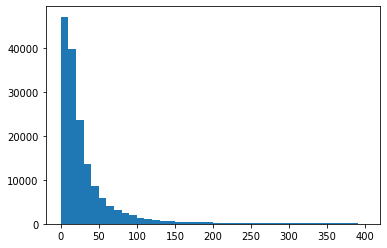

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y, train_size=0.8, random_state=233)

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [ ]:
def model():
    inputs = Input(shape=(maxlen,), name="input")
    layer = Embedding(max_features, 128, name="embedding")(inputs)
    #layer = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1, name="lstm_0"),name="bidrect_0")(layer)
    #layer = Bidirectional(LSTM(32, return_sequences=True, name="lstm_1"),name="bidrect_1")(layer)
    #layer = LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1, name="lstm_0")(layer)
    layer = Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, name="bi_gru_0"))(layer)
    layer = Conv1D(64, kernel_size = 3, padding = "valid", activation='relu', name="conv1d_0")(layer)
    layer = GlobalAveragePooling1D(name="avg_pool_0")(layer)
    #layer = GlobalMaxPool1D(name="max_pool_0")(layer)
    layer = Dense(32,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5,name="fc1_dropout")(layer)
    layer = Dense(6,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = model()

In [ ]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200, 128)          74496     
_________________________________________________________________
conv1d_0 (Conv1D)            (None, 198, 64)           24640     
_________________________________________________________________
avg_pool_0 (GlobalAveragePoo (None, 64)                0         
_________________________________________________________________
FC1 (Dense)                  (None, 32)                2080      
_________________________________________________________________
activation_10 (Activation)   (None, 32)              

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
checkpoint_path = os.path.join(MODEL_DIR,"lstm-custom-embeddings-v4.hdf5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, verbose=1)

ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)

In [ ]:
batch_size = 64
epochs = 10
history = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),shuffle=True, callbacks=[cp_callback,reduce_lr,ra_val])

Epoch 1/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.8628
Epoch 00001: val_accuracy improved from -inf to 0.99292, saving model to /content/drive/My Drive/NLP/toxic-comment-classification/models/lstm-custom-embeddings-v4.hdf5

 ROC-AUC - epoch: 1 - score: 0.968972
1995/1995 [==============================] - 1530s 767ms/step - loss: 0.0835 - accuracy: 0.8628 - val_loss: 0.0551 - val_accuracy: 0.9929
Epoch 2/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9926
Epoch 00002: val_accuracy improved from 0.99292 to 0.99383, saving model to /content/drive/My Drive/NLP/toxic-comment-classification/models/lstm-custom-embeddings-v4.hdf5

 ROC-AUC - epoch: 2 - score: 0.971576
1995/1995 [==============================] - 1523s 763ms/step - loss: 0.0562 - accuracy: 0.9926 - val_loss: 0.0525 - val_accuracy: 0.9938
Epoch 3/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9941
Epoch 00003: 